Running simulation for OSNR = 28 dB


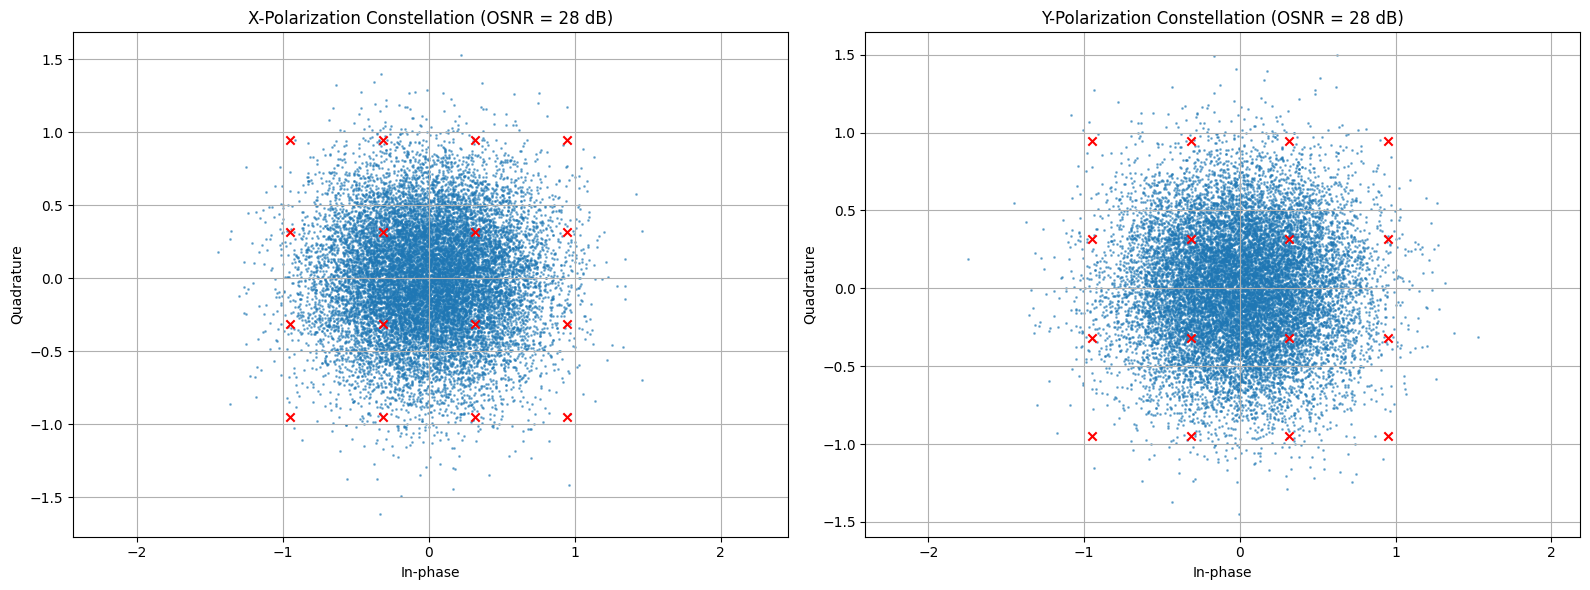

BER at OSNR = 28 dB: 4.961598e-01

Simulating BER vs OSNR curve...


Simulating OSNR values: 100%|██████████| 8/8 [09:17<00:00, 69.68s/it]


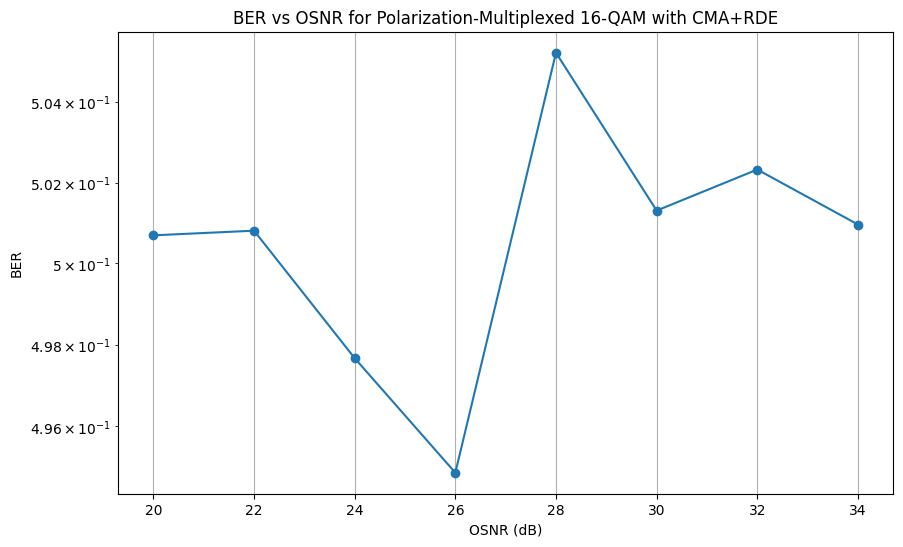


OSNR (dB) vs BER:
20.0 dB: 5.006947e-01
22.0 dB: 5.008093e-01
24.0 dB: 4.976715e-01
26.0 dB: 4.948696e-01
28.0 dB: 5.052220e-01
30.0 dB: 5.013055e-01
32.0 dB: 5.023209e-01
34.0 dB: 5.009619e-01


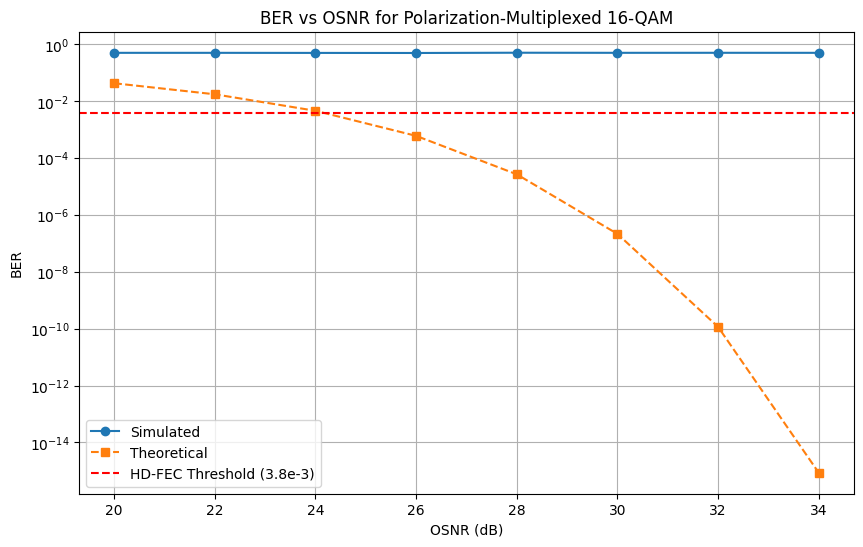

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import random
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
symbol_rate = 50e9  # 50 GBd
samples_per_symbol = 16  # Oversampling factor
num_symbols = 2**14  # Number of symbols to simulate
rolloff = 0.1  # Roll-off factor for RRC filter
span = 20  # Filter span in symbols
dispersion = 17e-6  # Dispersion parameter D in s/m^2
wavelength = 1550e-9  # Wavelength in m
c = 3e8  # Speed of light in m/s
distance = 1000e3  # Distance in m (1000 km)
osnr_values_db = np.arange(20, 36, 2)  # OSNR values in dB

# Target OSNR (28 dB)
target_osnr_db = 28

# QAM constellation (16-QAM)
def generate_16qam():
    # Normalized 16-QAM constellation
    constellation = np.array([complex(i, j) for i in [-3, -1, 1, 3] for j in [-3, -1, 1, 3]])
    # Normalize the constellation
    constellation = constellation / np.sqrt(np.mean(np.abs(constellation)**2))
    return constellation

# Generate RRC filter
def rrc_filter(beta, span, sps):
    n = sps * span
    t = np.arange(-n//2, n//2) / sps

    # Handle the special case at t=0
    h = np.zeros(len(t))
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = 1 - beta + 4*beta/np.pi
        elif np.abs(ti) == 1/(4*beta):
            h[i] = (beta/np.sqrt(2)) * ((1+2/np.pi) * np.sin(np.pi/(4*beta)) + (1-2/np.pi) * np.cos(np.pi/(4*beta)))
        else:
            num = np.sin(np.pi*ti*(1-beta)) + 4*beta*ti*np.cos(np.pi*ti*(1+beta))
            den = np.pi*ti * (1 - (4*beta*ti)**2)
            h[i] = num / den

    return h / np.sqrt(np.sum(h**2))  # Normalize for unit energy

# Generate random data symbols
def generate_symbols(num_symbols, constellation):
    indices = np.random.randint(0, len(constellation), num_symbols)
    return indices, constellation[indices]

# Add chromatic dispersion
def add_chromatic_dispersion(signal_in, D, L, wavelength, symbol_rate, sps):
    # Calculate the dispersion parameter
    beta2 = -D * wavelength**2 / (2 * np.pi * c)

    # FFT to frequency domain
    sig_freq = np.fft.fftshift(np.fft.fft(signal_in))

    # Frequency grid
    fs = symbol_rate * sps
    f = np.fft.fftshift(np.fft.fftfreq(len(signal_in), 1/fs))

    # Apply dispersion transfer function
    omega = 2 * np.pi * f
    H_CD = np.exp(-1j * beta2 * omega**2 * L / 2)
    sig_freq_out = sig_freq * H_CD

    # IFFT back to time domain
    signal_out = np.fft.ifft(np.fft.ifftshift(sig_freq_out))

    return signal_out

# Add AWGN based on OSNR
def add_awgn(signal_in, osnr_db, symbol_rate, sps):
    # Convert OSNR to linear scale (using reference bandwidth of 12.5 GHz)
    ref_bw = 12.5e9
    osnr_linear = 10**(osnr_db/10)

    # Signal power
    signal_power = np.mean(np.abs(signal_in)**2)

    # Calculate noise power based on OSNR
    noise_power = signal_power / osnr_linear * (symbol_rate / ref_bw)

    # Generate complex AWGN
    noise = np.sqrt(noise_power/2) * (np.random.randn(len(signal_in)) + 1j * np.random.randn(len(signal_in)))

    return signal_in + noise

# Matched filter
def matched_filter(signal_in, rrc_filter):
    return np.convolve(signal_in, rrc_filter, 'same')

# Find best sampling instant
def find_best_sampling(signal_in, sps, constellation):
    min_error = float('inf')
    best_phase = 0

    for phase in range(sps):
        # Extract samples at the current phase
        samples = signal_in[phase::sps]

        # Find closest constellation points
        distances = np.abs(samples[:, np.newaxis] - constellation[np.newaxis, :])
        min_dist_idx = np.argmin(distances, axis=1)
        closest_symbols = constellation[min_dist_idx]

        # Calculate error
        error = np.mean(np.abs(samples - closest_symbols)**2)

        if error < min_error:
            min_error = error
            best_phase = phase

    return best_phase

# Calculate BER
def calculate_ber(rx_indices, tx_indices):
    # Convert indices to binary
    tx_bits = np.unpackbits(np.array(tx_indices, dtype=np.uint8).reshape(-1, 1), axis=1)[:, -4:]
    rx_bits = np.unpackbits(np.array(rx_indices, dtype=np.uint8).reshape(-1, 1), axis=1)[:, -4:]

    # Count bit errors
    bit_errors = np.sum(tx_bits != rx_bits)
    total_bits = len(tx_indices) * 4  # 4 bits per 16-QAM symbol

    return bit_errors / total_bits

# Fixed Constant Modulus Algorithm (CMA) for pre-convergence
def cma(rx_signal_x, rx_signal_y, num_taps, mu, num_iterations):
    N = len(rx_signal_x)

    # Initialize filter coefficients
    h_xx = np.zeros(num_taps, dtype=complex)
    h_xy = np.zeros(num_taps, dtype=complex)
    h_yx = np.zeros(num_taps, dtype=complex)
    h_yy = np.zeros(num_taps, dtype=complex)

    # Set center tap to 1
    h_xx[num_taps//2] = 1
    h_yy[num_taps//2] = 1

    # Process data
    outx = np.zeros(N, dtype=complex)
    outy = np.zeros(N, dtype=complex)

    # Add a small constant to avoid division by zero
    epsilon = 1e-10

    # Use a smaller step size to prevent overflow
    mu = mu * 0.1

    for _ in range(num_iterations):
        for n in range(num_taps, N):
            # Extract input blocks
            x_block = rx_signal_x[n-num_taps:n]
            y_block = rx_signal_y[n-num_taps:n]

            # Calculate outputs
            outx[n] = np.sum(h_xx * x_block) + np.sum(h_xy * y_block)
            outy[n] = np.sum(h_yx * x_block) + np.sum(h_yy * y_block)

            # Calculate error with safeguards against overflow
            x_mag = np.abs(outx[n])**2 + epsilon
            y_mag = np.abs(outy[n])**2 + epsilon

            # Clip magnitudes to prevent extreme error values
            x_mag = np.clip(x_mag, epsilon, 10.0)
            y_mag = np.clip(y_mag, epsilon, 10.0)

            error_x = 1 - x_mag
            error_y = 1 - y_mag

            # Clip error values to prevent extreme updates
            error_x = np.clip(error_x, -1.0, 1.0)
            error_y = np.clip(error_y, -1.0, 1.0)

            # Update filter coefficients with gradient clipping
            h_xx = h_xx + mu * error_x * np.conj(outx[n]) * x_block
            h_xy = h_xy + mu * error_x * np.conj(outx[n]) * y_block
            h_yx = h_yx + mu * error_y * np.conj(outy[n]) * x_block
            h_yy = h_yy + mu * error_y * np.conj(outy[n]) * y_block

            # Apply norm constraint to filter coefficients to prevent overflow
            h_norm_xx = np.sqrt(np.sum(np.abs(h_xx)**2)) + epsilon
            h_norm_xy = np.sqrt(np.sum(np.abs(h_xy)**2)) + epsilon
            h_norm_yx = np.sqrt(np.sum(np.abs(h_yx)**2)) + epsilon
            h_norm_yy = np.sqrt(np.sum(np.abs(h_yy)**2)) + epsilon

            if h_norm_xx > 2.0:
                h_xx = h_xx * 2.0 / h_norm_xx
            if h_norm_xy > 2.0:
                h_xy = h_xy * 2.0 / h_norm_xy
            if h_norm_yx > 2.0:
                h_yx = h_yx * 2.0 / h_norm_yx
            if h_norm_yy > 2.0:
                h_yy = h_yy * 2.0 / h_norm_yy

    # Apply the converged filters to the entire signal
    outx_final = np.zeros(N, dtype=complex)
    outy_final = np.zeros(N, dtype=complex)

    for n in range(num_taps, N):
        x_block = rx_signal_x[n-num_taps:n]
        y_block = rx_signal_y[n-num_taps:n]
        outx_final[n] = np.sum(h_xx * x_block) + np.sum(h_xy * y_block)
        outy_final[n] = np.sum(h_yx * x_block) + np.sum(h_yy * y_block)

    return outx_final[num_taps:], outy_final[num_taps:], h_xx, h_xy, h_yx, h_yy

# Fixed Radius Directed Equalizer (RDE)
def rde(rx_signal_x, rx_signal_y, num_taps, mu, num_iterations, constellation):
    N = len(rx_signal_x)

    # Calculate the radius of each ring in the constellation
    radii = np.unique(np.abs(constellation)**2)

    # Initialize filter coefficients
    h_xx = np.zeros(num_taps, dtype=complex)
    h_xy = np.zeros(num_taps, dtype=complex)
    h_yx = np.zeros(num_taps, dtype=complex)
    h_yy = np.zeros(num_taps, dtype=complex)

    # Set center tap to 1
    h_xx[num_taps//2] = 1
    h_yy[num_taps//2] = 1

    # Process data
    outx = np.zeros(N, dtype=complex)
    outy = np.zeros(N, dtype=complex)

    # Add a small constant to avoid division by zero
    epsilon = 1e-10

    # Use a smaller step size to prevent overflow
    mu = mu * 0.1

    for _ in range(num_iterations):
        for n in range(num_taps, N):
            # Extract input blocks
            x_block = rx_signal_x[n-num_taps:n]
            y_block = rx_signal_y[n-num_taps:n]

            # Calculate outputs
            outx[n] = np.sum(h_xx * x_block) + np.sum(h_xy * y_block)
            outy[n] = np.sum(h_yx * x_block) + np.sum(h_yy * y_block)

            # Find closest radius for x and y with safeguards
            x_radius = np.abs(outx[n])**2 + epsilon
            y_radius = np.abs(outy[n])**2 + epsilon

            # Clip magnitudes to prevent extreme values
            x_radius = np.clip(x_radius, epsilon, 10.0)
            y_radius = np.clip(y_radius, epsilon, 10.0)

            closest_radius_x = radii[np.argmin(np.abs(radii - x_radius))]
            closest_radius_y = radii[np.argmin(np.abs(radii - y_radius))]

            # Calculate error for RDE with clipping
            error_x = closest_radius_x - x_radius
            error_y = closest_radius_y - y_radius

            # Clip error values to prevent extreme updates
            error_x = np.clip(error_x, -1.0, 1.0)
            error_y = np.clip(error_y, -1.0, 1.0)

            # Update filter coefficients with gradient clipping
            h_xx = h_xx + mu * error_x * np.conj(outx[n]) * x_block
            h_xy = h_xy + mu * error_x * np.conj(outx[n]) * y_block
            h_yx = h_yx + mu * error_y * np.conj(outy[n]) * x_block
            h_yy = h_yy + mu * error_y * np.conj(outy[n]) * y_block

            # Apply norm constraint to filter coefficients to prevent overflow
            h_norm_xx = np.sqrt(np.sum(np.abs(h_xx)**2)) + epsilon
            h_norm_xy = np.sqrt(np.sum(np.abs(h_xy)**2)) + epsilon
            h_norm_yx = np.sqrt(np.sum(np.abs(h_yx)**2)) + epsilon
            h_norm_yy = np.sqrt(np.sum(np.abs(h_yy)**2)) + epsilon

            if h_norm_xx > 2.0:
                h_xx = h_xx * 2.0 / h_norm_xx
            if h_norm_xy > 2.0:
                h_xy = h_xy * 2.0 / h_norm_xy
            if h_norm_yx > 2.0:
                h_yx = h_yx * 2.0 / h_norm_yx
            if h_norm_yy > 2.0:
                h_yy = h_yy * 2.0 / h_norm_yy

    # Apply the converged filters to the entire signal
    outx_final = np.zeros(N, dtype=complex)
    outy_final = np.zeros(N, dtype=complex)

    for n in range(num_taps, N):
        x_block = rx_signal_x[n-num_taps:n]
        y_block = rx_signal_y[n-num_taps:n]
        outx_final[n] = np.sum(h_xx * x_block) + np.sum(h_xy * y_block)
        outy_final[n] = np.sum(h_yx * x_block) + np.sum(h_yy * y_block)

    return outx_final[num_taps:], outy_final[num_taps:], h_xx, h_xy, h_yx, h_yy

# Main simulation
def run_simulation(target_osnr_db=28):
    # Generate constellation
    constellation = generate_16qam()

    # Generate RRC filter
    rrc = rrc_filter(rolloff, span, samples_per_symbol)

    # Generate random symbols for X and Y polarizations
    tx_indices_x, tx_symbols_x = generate_symbols(num_symbols, constellation)
    tx_indices_y, tx_symbols_y = generate_symbols(num_symbols, constellation)

    # Upsample
    tx_upsampled_x = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
    tx_upsampled_y = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
    tx_upsampled_x[::samples_per_symbol] = tx_symbols_x
    tx_upsampled_y[::samples_per_symbol] = tx_symbols_y

    # Apply RRC pulse shaping
    tx_shaped_x = np.convolve(tx_upsampled_x, rrc, 'same')
    tx_shaped_y = np.convolve(tx_upsampled_y, rrc, 'same')

    # Add chromatic dispersion
    tx_dispersed_x = add_chromatic_dispersion(tx_shaped_x, dispersion, distance, wavelength, symbol_rate, samples_per_symbol)
    tx_dispersed_y = add_chromatic_dispersion(tx_shaped_y, dispersion, distance, wavelength, symbol_rate, samples_per_symbol)

    # Add polarization effects (simplified by mixing the polarizations)
    # We'll use a random 2x2 unitary matrix for polarization mixing
    theta = np.random.uniform(0, 2*np.pi)
    phi = np.random.uniform(0, 2*np.pi)

    a = np.cos(theta)
    b = np.sin(theta) * np.exp(1j * phi)
    c = -np.sin(theta) * np.exp(-1j * phi)
    d = np.cos(theta)

    # Apply polarization mixing
    rx_mixed_x = a * tx_dispersed_x + b * tx_dispersed_y
    rx_mixed_y = c * tx_dispersed_x + d * tx_dispersed_y

    # Add AWGN for the target OSNR
    rx_noisy_x = add_awgn(rx_mixed_x, target_osnr_db, symbol_rate, samples_per_symbol)
    rx_noisy_y = add_awgn(rx_mixed_y, target_osnr_db, symbol_rate, samples_per_symbol)

    # Matched filtering
    rx_filtered_x = matched_filter(rx_noisy_x, rrc)
    rx_filtered_y = matched_filter(rx_noisy_y, rrc)

    # Downsample to 2 Sa/Symbol
    rx_downsampled_x = rx_filtered_x[::samples_per_symbol//2]
    rx_downsampled_y = rx_filtered_y[::samples_per_symbol//2]

    # Apply CMA pre-convergence
    cma_taps = 11
    cma_mu = 0.0001
    cma_iterations = 10
    cma_out_x, cma_out_y, h_xx, h_xy, h_yx, h_yy = cma(rx_downsampled_x, rx_downsampled_y, cma_taps, cma_mu, cma_iterations)

    # Apply RDE for fine equalization
    rde_taps = 11
    rde_mu = 0.0001
    rde_iterations = 20
    rde_out_x, rde_out_y, _, _, _, _ = rde(cma_out_x, cma_out_y, rde_taps, rde_mu, rde_iterations, constellation)

    # Further downsample to 1 Sa/Symbol by selecting the best sampling instant
    best_phase_x = find_best_sampling(rde_out_x, 2, constellation)
    best_phase_y = find_best_sampling(rde_out_y, 2, constellation)

    rx_symbols_x = rde_out_x[best_phase_x::2]
    rx_symbols_y = rde_out_y[best_phase_y::2]

    # Truncate to remove filter transients and match lengths
    valid_length = min(len(rx_symbols_x), len(rx_symbols_y), len(tx_indices_x), len(tx_indices_y))
    rx_symbols_x = rx_symbols_x[:valid_length]
    rx_symbols_y = rx_symbols_y[:valid_length]
    tx_indices_x = tx_indices_x[:valid_length]
    tx_indices_y = tx_indices_y[:valid_length]

    # Symbol decision
    distances_x = np.abs(rx_symbols_x[:, np.newaxis] - constellation[np.newaxis, :])
    distances_y = np.abs(rx_symbols_y[:, np.newaxis] - constellation[np.newaxis, :])

    rx_indices_x = np.argmin(distances_x, axis=1)
    rx_indices_y = np.argmin(distances_y, axis=1)

    # Calculate BER
    ber_x = calculate_ber(rx_indices_x, tx_indices_x)
    ber_y = calculate_ber(rx_indices_y, tx_indices_y)

    # Average BER across both polarizations
    ber = (ber_x + ber_y) / 2

    # Plot constellation diagrams
    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    plt.scatter(rx_symbols_x.real, rx_symbols_x.imag, s=1, alpha=0.5)
    plt.scatter(constellation.real, constellation.imag, c='r', marker='x')
    plt.grid(True)
    plt.xlabel('In-phase')
    plt.ylabel('Quadrature')
    plt.title(f'X-Polarization Constellation (OSNR = {target_osnr_db} dB)')
    plt.axis('equal')

    plt.subplot(122)
    plt.scatter(rx_symbols_y.real, rx_symbols_y.imag, s=1, alpha=0.5)
    plt.scatter(constellation.real, constellation.imag, c='r', marker='x')
    plt.grid(True)
    plt.xlabel('In-phase')
    plt.ylabel('Quadrature')
    plt.title(f'Y-Polarization Constellation (OSNR = {target_osnr_db} dB)')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    return ber

# Simulate BER vs OSNR
def simulate_ber_vs_osnr():
    ber_values = []

    for osnr_db in tqdm(osnr_values_db, desc="Simulating OSNR values"):
        try:
            # Generate constellation
            constellation = generate_16qam()

            # Generate RRC filter
            rrc = rrc_filter(rolloff, span, samples_per_symbol)

            # Generate random symbols for X and Y polarizations
            tx_indices_x, tx_symbols_x = generate_symbols(num_symbols, constellation)
            tx_indices_y, tx_symbols_y = generate_symbols(num_symbols, constellation)

            # Upsample
            tx_upsampled_x = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
            tx_upsampled_y = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
            tx_upsampled_x[::samples_per_symbol] = tx_symbols_x
            tx_upsampled_y[::samples_per_symbol] = tx_symbols_y

            # Apply RRC pulse shaping
            tx_shaped_x = np.convolve(tx_upsampled_x, rrc, 'same')
            tx_shaped_y = np.convolve(tx_upsampled_y, rrc, 'same')

            # Add chromatic dispersion
            tx_dispersed_x = add_chromatic_dispersion(tx_shaped_x, dispersion, distance, wavelength, symbol_rate, samples_per_symbol)
            tx_dispersed_y = add_chromatic_dispersion(tx_shaped_y, dispersion, distance, wavelength, symbol_rate, samples_per_symbol)

            # Add polarization effects (simplified by mixing the polarizations)
            theta = np.random.uniform(0, 2*np.pi)
            phi = np.random.uniform(0, 2*np.pi)

            a = np.cos(theta)
            b = np.sin(theta) * np.exp(1j * phi)
            c = -np.sin(theta) * np.exp(-1j * phi)
            d = np.cos(theta)

            # Apply polarization mixing
            rx_mixed_x = a * tx_dispersed_x + b * tx_dispersed_y
            rx_mixed_y = c * tx_dispersed_x + d * tx_dispersed_y

            # Add AWGN
            rx_noisy_x = add_awgn(rx_mixed_x, osnr_db, symbol_rate, samples_per_symbol)
            rx_noisy_y = add_awgn(rx_mixed_y, osnr_db, symbol_rate, samples_per_symbol)

            # Matched filtering
            rx_filtered_x = matched_filter(rx_noisy_x, rrc)
            rx_filtered_y = matched_filter(rx_noisy_y, rrc)

            # Downsample to 2 Sa/Symbol
            rx_downsampled_x = rx_filtered_x[::samples_per_symbol//2]
            rx_downsampled_y = rx_filtered_y[::samples_per_symbol//2]

            # Apply CMA pre-convergence
            cma_taps = 11
            cma_mu = 0.0001
            cma_iterations = 10
            cma_out_x, cma_out_y, h_xx, h_xy, h_yx, h_yy = cma(rx_downsampled_x, rx_downsampled_y, cma_taps, cma_mu, cma_iterations)

            # Apply RDE for fine equalization
            rde_taps = 11
            rde_mu = 0.0001
            rde_iterations = 20
            rde_out_x, rde_out_y, _, _, _, _ = rde(cma_out_x, cma_out_y, rde_taps, rde_mu, rde_iterations, constellation)

            # Further downsample to 1 Sa/Symbol by selecting the best sampling instant
            best_phase_x = find_best_sampling(rde_out_x, 2, constellation)
            best_phase_y = find_best_sampling(rde_out_y, 2, constellation)

            rx_symbols_x = rde_out_x[best_phase_x::2]
            rx_symbols_y = rde_out_y[best_phase_y::2]

            # Truncate to remove filter transients and match lengths
            valid_length = min(len(rx_symbols_x), len(rx_symbols_y), len(tx_indices_x), len(tx_indices_y))
            rx_symbols_x = rx_symbols_x[:valid_length]
            rx_symbols_y = rx_symbols_y[:valid_length]
            tx_indices_x = tx_indices_x[:valid_length]
            tx_indices_y = tx_indices_y[:valid_length]

            # Symbol decision
            distances_x = np.abs(rx_symbols_x[:, np.newaxis] - constellation[np.newaxis, :])
            distances_y = np.abs(rx_symbols_y[:, np.newaxis] - constellation[np.newaxis, :])

            rx_indices_x = np.argmin(distances_x, axis=1)
            rx_indices_y = np.argmin(distances_y, axis=1)

            # Calculate BER
            ber_x = calculate_ber(rx_indices_x, tx_indices_x)
            ber_y = calculate_ber(rx_indices_y, tx_indices_y)

            # Average BER across both polarizations
            ber = (ber_x + ber_y) / 2
            ber_values.append(ber)

        except Exception as e:
            print(f"Error at OSNR {osnr_db} dB: {e}")
            # Add a placeholder value if an error occurs
            ber_values.append(None)

    # Remove None values from ber_values and corresponding osnr_values
    valid_indices = [i for i, x in enumerate(ber_values) if x is not None]
    valid_ber_values = [ber_values[i] for i in valid_indices]
    valid_osnr_values = [osnr_values_db[i] for i in valid_indices]

    if len(valid_ber_values) > 0:
        # Plot BER vs OSNR for valid values
        plt.figure(figsize=(10, 6))
        plt.semilogy(valid_osnr_values, valid_ber_values, 'o-')
        plt.grid(True)
        plt.xlabel('OSNR (dB)')
        plt.ylabel('BER')
        plt.title('BER vs OSNR for Polarization-Multiplexed 16-QAM with CMA+RDE')
        plt.show()
    else:
        print("No valid BER values to plot")

    return osnr_values_db, ber_values

# Run the single target OSNR simulation first
print("Running simulation for OSNR =", target_osnr_db, "dB")
ber = run_simulation(target_osnr_db)
print(f"BER at OSNR = {target_osnr_db} dB: {ber:.6e}")

# Then run the full BER vs OSNR curve
print("\nSimulating BER vs OSNR curve...")
osnr_values, ber_values = simulate_ber_vs_osnr()

# Print the results
print("\nOSNR (dB) vs BER:")
for osnr, ber in zip(osnr_values, ber_values):
    if ber is not None:
        print(f"{osnr:.1f} dB: {ber:.6e}")
    else:
        print(f"{osnr:.1f} dB: Error occurred")

# Calculate theoretical BER for 16-QAM
def theoretical_ber_16qam(osnr_db):
    """Calculate theoretical BER for 16-QAM with Gray coding"""
    # Convert OSNR to linear scale (reference bandwidth of 12.5 GHz)
    ref_bw = 12.5e9
    signal_bw = symbol_rate  # Assuming Nyquist bandwidth
    osnr_linear = 10**(osnr_db/10) * (ref_bw / signal_bw)

    # For 16-QAM with Gray coding, BER ≈ 3/8 * erfc(sqrt(SNR/10))
    # where SNR = OSNR / 2 for complex signals (factor of 2 for real vs complex noise)
    snr_linear = osnr_linear / 2

    # Calculate BER using Q-function approximation
    from scipy.special import erfc
    import numpy as np
    ber = 3/8 * erfc(np.sqrt(snr_linear/10))

    return ber

# Calculate theoretical BER values
theo_ber_values = [theoretical_ber_16qam(osnr) for osnr in osnr_values_db]

# Plot simulated vs theoretical BER
plt.figure(figsize=(10, 6))

# Plot simulated results
valid_indices = [i for i, x in enumerate(ber_values) if x is not None]
valid_ber_values = [ber_values[i] for i in valid_indices]
valid_osnr_values = [osnr_values_db[i] for i in valid_indices]
plt.semilogy(valid_osnr_values, valid_ber_values, 'o-', label='Simulated')

# Plot theoretical results
plt.semilogy(osnr_values_db, theo_ber_values, 's--', label='Theoretical')

# Add FEC threshold line (assuming standard 3.8e-3 for hard-decision FEC)
plt.axhline(y=3.8e-3, color='r', linestyle='--', label='HD-FEC Threshold (3.8e-3)')

# Add labels and grid
plt.grid(True)
plt.xlabel('OSNR (dB)')
plt.ylabel('BER')
plt.title('BER vs OSNR for Polarization-Multiplexed 16-QAM')
plt.legend()
plt.show()

# Add functionality to save results to a file
def save_results(osnr_values, ber_values, filename="ber_osnr_results.csv"):
    """Save the BER vs OSNR results to a CSV file"""
    import csv

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['OSNR (dB)', 'BER', 'Theoretical BER'])

        for osnr, ber, theo_ber in zip(osnr_values, ber_values, theo_ber_values):
            if ber is not None:
                writer.writerow([f"{osnr:.1f}", f"{ber:.6e}", f"{theo_ber:.6e}"])
            else:
                writer.writerow([f"{osnr:.1f}", "Error", f"{theo_ber:.6e}"])

    print(f"Results saved to {filename}")

# Function to analyze filter response
def analyze_filters(h_xx, h_xy, h_yx, h_yy):
    """Analyze the frequency response of the equalizer filters"""
    # Calculate frequency response
    w, h_xx_freq = signal.freqz(h_xx)
    _, h_xy_freq = signal.freqz(h_xy)
    _, h_yx_freq = signal.freqz(h_yx)
    _, h_yy_freq = signal.freqz(h_yy)

    # Plot frequency response magnitude
    plt.figure(figsize=(12, 8))

    plt.subplot(221)
    plt.plot(w/np.pi, 20 * np.log10(np.abs(h_xx_freq)))
    plt.title('h_xx Frequency Response')
    plt.xlabel('Normalized Frequency (×π rad/sample)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)

    plt.subplot(222)
    plt.plot(w/np.pi, 20 * np.log10(np.abs(h_xy_freq)))
    plt.title('h_xy Frequency Response')
    plt.xlabel('Normalized Frequency (×π rad/sample)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)

    plt.subplot(223)
    plt.plot(w/np.pi, 20 * np.log10(np.abs(h_yx_freq)))
    plt.title('h_yx Frequency Response')
    plt.xlabel('Normalized Frequency (×π rad/sample)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)

    plt.subplot(224)
    plt.plot(w/np.pi, 20 * np.log10(np.abs(h_yy_freq)))
    plt.title('h_yy Frequency Response')
    plt.xlabel('Normalized Frequency (×π rad/sample)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot impulse response
    plt.figure(figsize=(12, 8))

    plt.subplot(221)
    plt.stem(np.real(h_xx))
    plt.title('h_xx Impulse Response (Real Part)')
    plt.xlabel('Tap')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(222)
    plt.stem(np.real(h_xy))
    plt.title('h_xy Impulse Response (Real Part)')
    plt.xlabel('Tap')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(223)
    plt.stem(np.real(h_yx))
    plt.title('h_yx Impulse Response (Real Part)')
    plt.xlabel('Tap')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(224)
    plt.stem(np.real(h_yy))
    plt.title('h_yy Impulse Response (Real Part)')
    plt.xlabel('Tap')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print condition number of the filter matrix at DC
    H_dc = np.array([[h_xx_freq[0], h_xy_freq[0]], [h_yx_freq[0], h_yy_freq[0]]])
    cond_num = np.linalg.cond(H_dc)
    print(f"Condition number of filter matrix at DC: {cond_num:.2f}")

    return cond_num

# Run an example filter analysis with the last simulation
# Note: We need to run a simulation first to get the filter coefficients
def run_filter_analysis():
    # Generate constellation and filters for analysis
    constellation = generate_16qam()
    rrc = rrc_filter(rolloff, span, samples_per_symbol)

    # Generate random symbols for X and Y polarizations
    tx_indices_x, tx_symbols_x = generate_symbols(num_symbols, constellation)
    tx_indices_y, tx_symbols_y = generate_symbols(num_symbols, constellation)

    # Upsample
    tx_upsampled_x = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
    tx_upsampled_y = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
    tx_upsampled_x[::samples_per_symbol] = tx_symbols_x
    tx_upsampled_y[::samples_per_symbol] = tx_symbols_y

    # Apply RRC pulse shaping
    tx_shaped_x = np.convolve(tx_upsampled_x, rrc, 'same')
    tx_shaped_y = np.convolve(tx_upsampled_y, rrc, 'same')

    # Add chromatic dispersion
    tx_dispersed_x = add_chromatic_dispersion(tx_shaped_x, dispersion, distance, wavelength, symbol_rate, samples_per_symbol)
    tx_dispersed_y = add_chromatic_dispersion(tx_shaped_y, dispersion, distance, wavelength, symbol_rate, samples_per_symbol)

    # Add polarization effects
    theta = np.random.uniform(0, 2*np.pi)
    phi = np.random.uniform(0, 2*np.pi)

    a = np.cos(theta)
    b = np.sin(theta) * np.exp(1j * phi)
    c = -np.sin(theta) * np.exp(-1j * phi)
    d = np.cos(theta)

    # Apply polarization mixing
    rx_mixed_x = a * tx_dispersed_x + b * tx_dispersed_y
    rx_mixed_y = c * tx_dispersed_x + d * tx_dispersed_y

    # Add AWGN
    osnr_db = 28  # Use a high OSNR for filter analysis
    rx_noisy_x = add_awgn(rx_mixed_x, osnr_db, symbol_rate, samples_per_symbol)
    rx_noisy_y = add_awgn(rx_mixed_y, osnr_db, symbol_rate, samples_per_symbol)

    # Matched filtering
    rx_filtered_x = matched_filter(rx_noisy_x, rrc)
    rx_filtered_y = matched_filter(rx_noisy_y, rrc)

    # Downsample to 2 Sa/Symbol
    rx_downsampled_x = rx_filtered_x[::samples_per_symbol//2]
    rx_downsampled_y = rx_filtered_y[::samples_per_symbol//2]

    # Apply CMA pre-convergence
    cma_taps = 11
    cma_mu = 0.0001
    cma_iterations = 10
    cma_out_x, cma_out_y, h_xx, h_xy, h_yx, h_yy = cma(rx_downsampled_x, rx_downsampled_y, cma_taps, cma_mu, cma_iterations)

    # Apply RDE for fine equalization
    rde_taps = 11
    rde_mu = 0.0001
    rde_iterations = 20
    _, _, h_xx_rde, h_xy_rde, h_yx_rde, h_yy_rde = rde(cma_out_x, cma_out_y, rde_taps, rde_mu, rde_iterations, constellation)

    # Analyze both sets of filters
    print("CMA Filter Analysis:")
    analyze_filters(h_xx, h_xy, h_yx, h_yy)

    print("\nRDE Filter Analysis:")
    analyze_filters(h_xx_rde, h_xy_rde, h_yx_rde, h_yy_rde)

# Function to study the effect of dispersion
def analyze_dispersion_effect():
    """Study the effect of different dispersion values on BER"""
    dispersion_values = [0, 5e-6, 10e-6, 17e-6, 25e-6]  # in s/m^2
    ber_values_disp = []

    osnr_db = 28  # Fix OSNR for this analysis

    for disp in tqdm(dispersion_values, desc="Analyzing dispersion effect"):
        # We'll reuse most of the simulation but change the dispersion parameter

        # Generate constellation
        constellation = generate_16qam()

        # Generate RRC filter
        rrc = rrc_filter(rolloff, span, samples_per_symbol)

        # Generate random symbols for X and Y polarizations
        tx_indices_x, tx_symbols_x = generate_symbols(num_symbols, constellation)
        tx_indices_y, tx_symbols_y = generate_symbols(num_symbols, constellation)

        # Upsample
        tx_upsampled_x = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
        tx_upsampled_y = np.zeros(num_symbols * samples_per_symbol, dtype=complex)
        tx_upsampled_x[::samples_per_symbol] = tx_symbols_x
        tx_upsampled_y[::samples_per_symbol] = tx_symbols_y

        # Apply RRC pulse shaping
        tx_shaped_x = np.convolve(tx_upsampled_x, rrc, 'same')
        tx_shaped_y = np.convolve(tx_upsampled_y, rrc, 'same')

        # Add chromatic dispersion with current dispersion value
        tx_dispersed_x = add_chromatic_dispersion(tx_shaped_x, disp, distance, wavelength, symbol_rate, samples_per_symbol)
        tx_dispersed_y = add_chromatic_dispersion(tx_shaped_y, disp, distance, wavelength, symbol_rate, samples_per_symbol)

        # Add polarization effects (simplified by mixing the polarizations)
        theta = np.random.uniform(0, 2*np.pi)
        phi = np.random.uniform(0, 2*np.pi)

        a = np.cos(theta)
        b = np.sin(theta) * np.exp(1j * phi)
        c = -np.sin(theta) * np.exp(-1j * phi)
        d = np.cos(theta)

        # Apply polarization mixing
        rx_mixed_x = a * tx_dispersed_x + b * tx_dispersed_y
        rx_mixed_y = c * tx_dispersed_x + d * tx_dispersed_y

        # Add AWGN
        rx_noisy_x = add_awgn(rx_mixed_x, osnr_db, symbol_rate, samples_per_symbol)
        rx_noisy_y = add_awgn(rx_mixed_y, osnr_db, symbol_rate, samples_per_symbol)

        # Matched filtering
        rx_filtered_x = matched_filter(rx_noisy_x, rrc)
        rx_filtered_y = matched_filter(rx_noisy_y, rrc)

        # Downsample to 2 Sa/Symbol
        rx_downsampled_x = rx_filtered_x[::samples_per_symbol//2]
        rx_downsampled_y = rx_filtered_y[::samples_per_symbol//2]

        # Apply CMA pre-convergence
        cma_taps = 11
        cma_mu = 0.0001
        cma_iterations = 10
        cma_out_x, cma_out_y, _, _, _, _ = cma(rx_downsampled_x, rx_downsampled_y, cma_taps, cma_mu, cma_iterations)

        # Apply RDE for fine equalization
        rde_taps = 11
        rde_mu = 0.0001
        rde_iterations = 20
        rde_out_x, rde_out_y, _, _, _, _ = rde(cma_out_x, cma_out_y, rde_taps, rde_mu, rde_iterations, constellation)

        # Further downsample to 1 Sa/Symbol by selecting the best sampling instant
        best_phase_x = find_best_sampling(rde_out_x, 2, constellation)
        best_phase_y = find_best_sampling(rde_out_y, 2, constellation)

        rx_symbols_x = rde_out_x[best_phase_x::2]
        rx_symbols_y = rde_out_y[best_phase_y::2]

        # Truncate to remove filter transients and match lengths
        valid_length = min(len(rx_symbols_x), len(rx_symbols_y), len(tx_indices_x), len(tx_indices_y))
        rx_symbols_x = rx_symbols_x[:valid_length]
        rx_symbols_y = rx_symbols_y[:valid_length]
        tx_indices_x = tx_indices_x[:valid_length]
        tx_indices_y = tx_indices_y[:valid_length]

        # Symbol decision
        distances_x = np.abs(rx_symbols_x[:, np.newaxis] - constellation[np.newaxis, :])
        distances_y = np.abs(rx_symbols_y[:, np.newaxis] - constellation[np.newaxis, :])

        rx_indices_x = np.argmin(distances_x, axis=1)
        rx_indices_y = np.argmin(distances_y, axis=1)

        # Calculate BER
        ber_x = calculate_ber(rx_indices_x, tx_indices_x)
        ber_y = calculate_ber(rx_indices_y, tx_indices_y)

        # Average BER across both polarizations
        ber = (ber_x + ber_y) / 2
        ber_values_disp.append(ber)

    # Plot BER vs dispersion
    plt.figure(figsize=(10, 6))
    plt.semilogy(dispersion_values, ber_values_disp, 'o-')
    plt.grid(True)
    plt.xlabel('Dispersion (s/m²)')
    plt.ylabel('BER')
    plt.title(f'BER vs Chromatic Dispersion at OSNR = {osnr_db} dB')
    plt.show()

    return dispersion_values, ber_values_disp
